In [ ]:
!unzip '/content/linkedin_124k_kaggle_filterd.zip'


unzip:  cannot find or open path_jobs, path_jobs.zip or path_jobs.ZIP.


In [ ]:
path_courses = '/content/courses.pkl'
path_jobs = '/content/linkedin_124k_kaggle_filterd.csv'

In [ ]:
import pandas as pd

# קריאת הקובץ
df = pd.read_pickle(path_courses)

# מציאת כפילויות
duplicates = df[df.duplicated()]

# הצגת מידע
print(f"סך הכל שורות: {len(df)}")
print(f"מספר שורות כפולות: {len(duplicates)}")
print("\nהשורות הכפולות:")


# הצגת אילו עמודות גורמות לכפילויות
duplicate_rows = df[df.duplicated(keep=False)]
print("\nקבוצות של שורות כפולות:")
print(duplicate_rows.sort_values(by=list(df.columns)))

סך הכל שורות: 1705
מספר שורות כפולות: 429

השורות הכפולות:

קבוצות של שורות כפולות:
                                                  title  \
728   A Beginner's Guide to Environmental Science: W...   
1603  A Beginner's Guide to Environmental Science: W...   
345   A Beginner's Guide to Kubernetes for Container...   
1261  A Beginner's Guide to Kubernetes for Container...   
333   A Beginner’s Guide to Becoming a Blockchain De...   
...                                                 ...   
450   Utilising Social Science and Behaviour Change ...   
707   Utilising Social Science and Behaviour Change ...   
1123  Utilising Social Science and Behaviour Change ...   
393                        Working with Version Control   
678                        Working with Version Control   

                                                    url  \
728   https://www.futurelearn.com/courses/introducti...   
1603  https://www.futurelearn.com/courses/introducti...   
345   https://www.futurelearn.

In [ ]:
# הסרת כפילויות ושמירת השורה הראשונה מכל קבוצת כפילויות
df_no_duplicates = df.drop_duplicates()

# שמירה חזרה לקובץ
courses = df_no_duplicates
print(f"מספר שורות לפני: {len(df)}")
print(f"מספר שורות אחרי: {len(df_no_duplicates)}")
print(f"מספר שורות שנוקו: {len(df) - len(df_no_duplicates)}")




מספר שורות לפני: 1705
מספר שורות אחרי: 1276
מספר שורות שנוקו: 429
מספר הקורסים: 1276


In [ ]:
import pandas as pd

# קריאת הקובץ CSV לאחר חילוץ מה-ZIP
jobs = pd.read_csv(path_jobs)
print(f"מספר המשרות: {len(jobs)}")

מספר המשרות: 123849


In [ ]:
print("ערכים חסרים ב-text:", jobs['text'].isna().sum())
print("\nערכים חסרים בכל עמודה:")
print(jobs[['title', 'skills_desc', 'description']].isna().sum())

# נראה דוגמה לשורות בעייתיות
print("\nדוגמה לשורות עם NaN ב-text:")
print(jobs[jobs['text'].isna()].head())

In [ ]:
print("ערכים חסרים ב-text:", jobs['text'].isna().sum())
print("\nערכים חסרים בכל עמודה:")
print(jobs[['title', 'skills_desc', 'description']].isna().sum())



ערכים חסרים ב-text: 0

ערכים חסרים בכל עמודה:
title          0
skills_desc    0
description    0
dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


#לקיחת נתונים רלוונטים
jobs['skills_desc'] = jobs['skills_desc'].fillna('')
jobs['description'] = jobs['description'].fillna('')
jobs['text'] = jobs['title'] + ' ' + jobs['skills_desc']+ ' ' + jobs['description']
courses['text'] = courses['title'] + ' ' + courses['description']


# 2. המרה למטריצת TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# הכנת המטריצות
courses_tfidf = vectorizer.fit_transform(courses['text'])
jobs_tfidf = vectorizer.transform(jobs['text'])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# 1. חלוקת הקורסים לאשכולות
n_clusters = 15  # אפשר לשנות את מספר האשכולות
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
course_clusters = kmeans.fit_predict(courses_tfidf)

# הוספת מידע על האשכולות לדאטאפריים של הקורסים
courses['cluster'] = course_clusters

def find_courses_for_job(job_index, n_recommendations=5):
    # 2. מציאת האשכול הקרוב ביותר למשרה
    job_vector = jobs_tfidf[job_index]
    distances_to_centroids = kmeans.transform(job_vector)
    closest_cluster = np.argmin(distances_to_centroids)

    # 3. מציאת הקורסים מתוך האשכול הקרוב
    cluster_courses = courses[courses['cluster'] == closest_cluster]
    cluster_courses_vectors = vectorizer.transform(cluster_courses['text'])

    # 4. חישוב דמיון בין המשרה לקורסים באשכול
    similarities = cosine_similarity(job_vector, cluster_courses_vectors)
    top_indices = similarities[0].argsort()[-n_recommendations:][::-1]

    # הכנת התוצאות
    recommendations = pd.DataFrame({
        'Course Title': cluster_courses.iloc[top_indices]['title'].values,
        'Similarity Score': similarities[0][top_indices],
        'Cluster': closest_cluster
    })

    return recommendations

# דוגמה לשימוש:
print("משרה לדוגמה:")
print(f"Title: {jobs['title'].iloc[0]}")
print("\nהקורסים המומלצים:")
print(find_courses_for_job(0))

# לכל המשרות
all_recommendations = {}
for idx in range(len(jobs)):
    all_recommendations[jobs['title'].iloc[idx]] = find_courses_for_job(idx)



משרה לדוגמה:
Title: Marketing Coordinator

הקורסים המומלצים:
                                        Course Title  Similarity Score  \
0  Master Digital Marketing: Introduction to Mark...          0.271252   
1                                          Marketing          0.243514   
2          MSc Digital Marketing with Data Analytics          0.242485   
3                         Become a Marketing Manager          0.229663   
4                         Become a Marketing Manager          0.229663   

   Cluster  
0        4  
1        4  
2        4  
3        4  
4        4  


In [ ]:
# נציג כמה דוגמאות
n_examples = 3  # נציג 3 משרות לדוגמה

for idx in range(n_examples):
   print("\n" + "="*80)
   print(f"משרה {idx+1}:")
   print(f"כותרת: {jobs['title'].iloc[idx]}")
   print(f"תיאור: {jobs['description'].iloc[idx][:200]}...")  # רק 200 תווים ראשונים

   print("\nהקורסים המומלצים:")
   recommendations = find_courses_for_job(idx)
   for i, row in recommendations.iterrows():
       print(f"\nקורס {i+1}:")
       print(f"כותרת: {row['Course Title']}")
       print(f"ציון דמיון: {row['Similarity Score']:.4f}")
       print(f"אשכול: {row['Cluster']}")


משרה 1:
כותרת: Marketing Coordinator
תיאור: Job descriptionA leading real estate firm in New Jersey is seeking an administrative Marketing Coordinator with some experience in graphic design. You will be working closely with our fun, kind, ambit...

הקורסים המומלצים:

קורס 1:
כותרת: Master Digital Marketing: Introduction to Marketing
ציון דמיון: 0.2713
אשכול: 4

קורס 2:
כותרת: Marketing
ציון דמיון: 0.2435
אשכול: 4

קורס 3:
כותרת: MSc Digital Marketing with Data Analytics
ציון דמיון: 0.2425
אשכול: 4

קורס 4:
כותרת: Become a Marketing Manager
ציון דמיון: 0.2297
אשכול: 4

קורס 5:
כותרת: Become a Marketing Manager
ציון דמיון: 0.2297
אשכול: 4

משרה 2:
כותרת: Mental Health Therapist/Counselor
תיאור: At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help them with change, improvements and better quality of life. We believe in providing a secure, supportive ...

הקורסים המומלצים:

קורס 1:
כותרת: Supporting Individuals with Health Conditions Into Work: T

בודק k = 2...
בודק k = 3...
בודק k = 4...
בודק k = 5...
בודק k = 6...
בודק k = 7...
בודק k = 8...
בודק k = 9...
בודק k = 10...
בודק k = 11...
בודק k = 12...
בודק k = 13...
בודק k = 14...
בודק k = 15...
בודק k = 16...
בודק k = 17...
בודק k = 18...
בודק k = 19...
בודק k = 20...
בודק k = 21...
בודק k = 22...
בודק k = 23...
בודק k = 24...
בודק k = 25...
בודק k = 26...
בודק k = 27...
בודק k = 28...
בודק k = 29...
בודק k = 30...


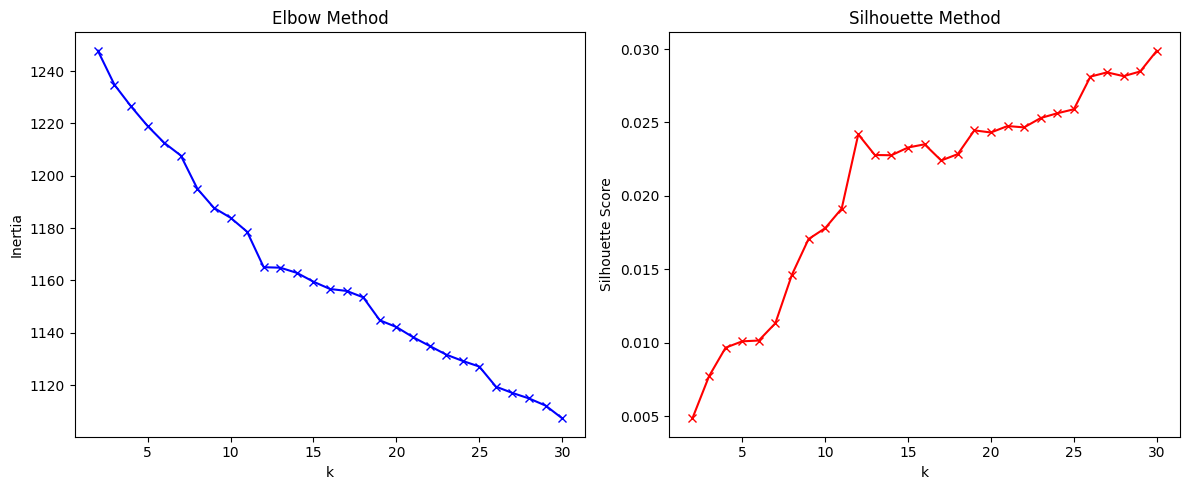


K האופטימלי לפי silhouette score: 30
K האופטימלי לפי elbow method: 12


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_k(data, k_range):
    inertias = []        # Within-cluster sum of squares
    silhouette_scores = []  # Silhouette score

    for k in k_range:
        print(f"בודק k = {k}...")

        # אימון המודל
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)

        # חישוב מדדים
        inertias.append(kmeans.inertia_)
        if k > 1:  # silhouette score requires at least 2 clusters
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
        else:
            silhouette_scores.append(0)

    return inertias, silhouette_scores

# טווח של k לבדיקה
k_range = range(2, 31)  # בודק k מ-2 עד 30

# חישוב המדדים
inertias, silhouette_scores = find_optimal_k(courses_tfidf, k_range)

# יצירת גרף
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')

plt.tight_layout()
plt.show()

# הדפסת הערכים הטובים ביותר
best_silhouette_k = k_range[np.argmax(silhouette_scores)]
print(f"\nK האופטימלי לפי silhouette score: {best_silhouette_k}")

# מציאת נקודת המרפק (elbow point)
# נשתמש בשיטה פשוטה - הנקודה עם השינוי הגדול ביותר בשיפוע
diffs = np.diff(inertias)
elbow_point = k_range[np.argmax(np.abs(np.diff(diffs))) + 1]
print(f"K האופטימלי לפי elbow method: {elbow_point}")

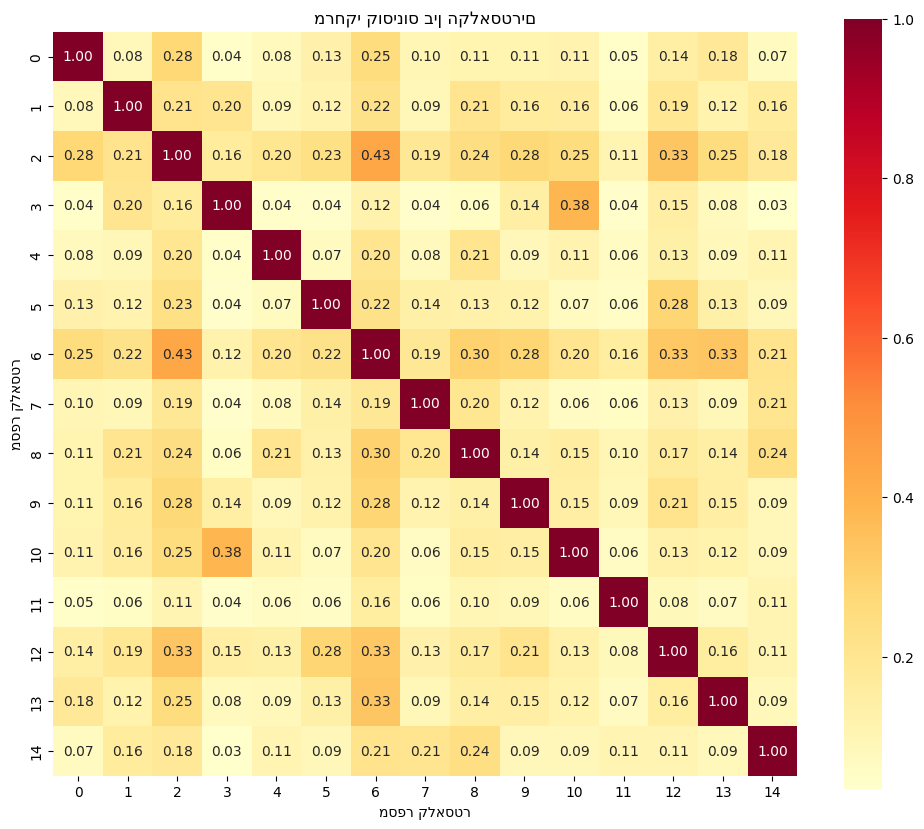


גודל כל קלאסטר:
קלאסטר 0: 89 קורסים
קלאסטר 1: 73 קורסים
קלאסטר 2: 130 קורסים
קלאסטר 3: 24 קורסים
קלאסטר 4: 42 קורסים
קלאסטר 5: 40 קורסים
קלאסטר 6: 329 קורסים
קלאסטר 7: 40 קורסים
קלאסטר 8: 79 קורסים
קלאסטר 9: 67 קורסים
קלאסטר 10: 64 קורסים
קלאסטר 11: 35 קורסים
קלאסטר 12: 136 קורסים
קלאסטר 13: 72 קורסים
קלאסטר 14: 56 קורסים

המילים המאפיינות כל קלאסטר:

קלאסטר 0: health, mental, wellbeing, care, people

קלאסטר 1: financial, finance, accounting, machine, learning

קלאסטר 2: skills, healthcare, online, science, courses

קלאסטר 3: azure, microsoft, data, python, ai

קלאסטר 4: marketing, digital, media, strategy, campaigns

קלאסטר 5: politics, neuroscience, study, pgce, practice

קלאסטר 6: sustainable, learn, discover, climate, explore

קלאסטר 7: leadership, management, skills, leader, development

קלאסטר 8: business, entrepreneurial, management, entrepreneurship, learn

קלאסטר 9: language, development, programming, software, web

קלאסטר 10: data, science, analytics, analysis, big

קלאסטר 1

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# יצירת המודל עם k=15
kmeans = KMeans(n_clusters=15, random_state=42)
course_clusters = kmeans.fit_predict(courses_tfidf)

# חישוב מרחקים בין הצנטרואידים
centroid_distances = cosine_similarity(kmeans.cluster_centers_)

# יצירת הויזואליזציה
plt.figure(figsize=(12, 10))
sns.heatmap(centroid_distances,
            annot=True,  # הצגת המספרים
            cmap='YlOrRd',  # צבעים מצהוב לאדום
            fmt='.2f',  # עיגול ל-2 ספרות אחרי הנקודה
            square=True)  # ריבוע מושלם

plt.title('מרחקי קוסינוס בין הקלאסטרים')
plt.xlabel('מספר קלאסטר')
plt.ylabel('מספר קלאסטר')
plt.show()

# הצגת מידע נוסף על הקלאסטרים
cluster_sizes = pd.Series(course_clusters).value_counts().sort_index()
print("\nגודל כל קלאסטר:")
for cluster, size in cluster_sizes.items():
    print(f"קלאסטר {cluster}: {size} קורסים")

# הצגת המילים המאפיינות כל קלאסטר
feature_names = vectorizer.get_feature_names_out()
n_top_words = 5

print("\nהמילים המאפיינות כל קלאסטר:")
for i in range(15):
    top_indices = kmeans.cluster_centers_[i].argsort()[-n_top_words:][::-1]
    top_words = [feature_names[ind] for ind in top_indices]
    print(f"\nקלאסטר {i}: {', '.join(top_words)}")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def find_courses_for_skills(skills_list, n_recommendations=5):
    # המרת רשימת הסקילים למטריצת TF-IDF
    # שימוש באותו vectorizer שאומן על הקורסים
    skills_tfidf = vectorizer.transform(skills_list)

    # מציאת הקלאסטר המתאים ביותר לכל סט סקילים
    cluster_assignments = kmeans.predict(skills_tfidf)

    recommendations_dict = {}

    for idx, skills in enumerate(skills_list):
        print(f"\nעבור סקילים: {skills}")

        # מציאת הקלאסטר המתאים
        cluster = cluster_assignments[idx]

        # סינון קורסים מהקלאסטר המתאים
        cluster_mask = course_clusters == cluster
        cluster_courses = courses[cluster_mask]
        cluster_vectors = courses_tfidf[cluster_mask]

        # חישוב דמיון בין הסקילים לקורסים
        similarities = cosine_similarity(skills_tfidf[idx], cluster_vectors)
        top_indices = similarities[0].argsort()[-n_recommendations:][::-1]

        # יצירת דאטאפריים עם התוצאות
        recommendations = pd.DataFrame({
            'Course Title': cluster_courses.iloc[top_indices]['title'].values,
            'Similarity Score': similarities[0][top_indices],
            'Cluster': cluster,
            'Description': cluster_courses.iloc[top_indices]['description'].values
        })

        recommendations_dict[skills] = recommendations

        print(f"\nקלאסטר שנבחר: {cluster}")
        print("\nקורסים מומלצים:")
        for i, row in recommendations.iterrows():
            print(f"\n{i+1}. {row['Course Title']}")
            print(f"ציון דמיון: {row['Similarity Score']:.4f}")

    return recommendations_dict

# שימוש בפונקציה עם הדוגמא שנתת
skills_to_test = [
   "Python programming, data analysis, and machine learning",
   "Digital marketing, SEO, and social media management",
   "Project management and team leadership"
]

recommendations = find_courses_for_skills(skills_to_test)




עבור סקילים: Python programming, data analysis, and machine learning

קלאסטר שנבחר: 10

קורסים מומלצים:

1. Microsoft Future Ready: Introduction to Python Programming
ציון דמיון: 0.5015

2. Introduction to Data Analytics with Python
ציון דמיון: 0.4425

3. Microsoft Future Ready: Data Science Research Methods Using Python Programming
ציון דמיון: 0.4113

4. Microsoft Future Ready: Data Science Research Methods Using Python Programming
ציון דמיון: 0.4113

5. Microsoft Future Ready: Data Science Research Methods on Python Programming
ציון דמיון: 0.3899

עבור סקילים: Digital marketing, SEO, and social media management

קלאסטר שנבחר: 4

קורסים מומלצים:

1. Digital Skills: Social Media
ציון דמיון: 0.6480

2. Create a Social Media Marketing Campaign
ציון דמיון: 0.4979

3. Introduction to Digital Media
ציון דמיון: 0.4845

4. Social Media Marketing Strategy: Objective Setting and Strategic Planning Essentials
ציון דמיון: 0.4829

5. Digital Media
ציון דמיון: 0.4678

עבור סקילים: Project manageme

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# מדגם קטן של משרות
sample_size = 1000  # למשל
jobs_sample = jobs.sample(n=sample_size, random_state=42)
courses_sample = courses.sample(n=1000, random_state=42)

# פונקציה להשוואת המודלים
def compare_models(jobs_df, courses_df, n_clusters=15, n_recommendations=5):
    # BERT
    print("מכין וקטורים עם BERT...")
    model = SentenceTransformer('all-MiniLM-L6-v2')

    courses_bert = model.encode(courses_df['text'].tolist())
    jobs_bert = model.encode(jobs_df['text'].tolist())

    # TF-IDF (כמו קודם)
    print("מכין וקטורים עם TF-IDF...")
    vectorizer = TfidfVectorizer(stop_words='english')
    courses_tfidf = vectorizer.fit_transform(courses_df['text'])
    jobs_tfidf = vectorizer.transform(jobs_df['text'])

    results = {}
    for method_name, courses_vectors, jobs_vectors in [
        ('BERT', courses_bert, jobs_bert),
        ('TF-IDF', courses_tfidf.toarray(), jobs_tfidf.toarray())
    ]:
        print(f"\nמריץ עם {method_name}...")

        # K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        course_clusters = kmeans.fit_predict(courses_vectors)

        # הוספת מידע על אשכולות
        courses_df['cluster'] = course_clusters

        method_results = []
        for idx in range(len(jobs_df)):
            job_vector = jobs_vectors[idx].reshape(1, -1)
            distances_to_centroids = kmeans.transform(job_vector)
            closest_cluster = np.argmin(distances_to_centroids)

            # מציאת קורסים באשכול
            cluster_courses = courses_df[courses_df['cluster'] == closest_cluster]
            cluster_vectors = courses_vectors[courses_df['cluster'] == closest_cluster]

            # חישוב דמיון
            similarities = cosine_similarity(job_vector, cluster_vectors)
            top_indices = similarities[0].argsort()[-n_recommendations:][::-1]

            recommendations = pd.DataFrame({
                'Job Title': jobs_df['title'].iloc[idx],
                'Course Title': cluster_courses.iloc[top_indices]['title'].values,
                'Similarity Score': similarities[0][top_indices],
                'Cluster': closest_cluster
            })

            method_results.append(recommendations)

        results[method_name] = pd.concat(method_results)

    return results

# הרצת ההשוואה
results = compare_models(jobs_sample, courses_sample)

# ניתוח התוצאות
for method in ['BERT', 'TF-IDF']:
    print(f"\nתוצאות עבור {method}:")
    print(f"ממוצע ציוני דמיון: {results[method]['Similarity Score'].mean():.4f}")
    print(f"חציון ציוני דמיון: {results[method]['Similarity Score'].median():.4f}")

    # הצגת כמה דוגמאות
    print("\nדוגמאות להתאמות:")
    sample_results = results[method].sample(n=3)
    for _, row in sample_results.iterrows():
        print(f"\nמשרה: {row['Job Title']}")
        print(f"קורס מומלץ: {row['Course Title']}")
        print(f"ציון דמיון: {row['Similarity Score']:.4f}")

מכין וקטורים עם BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

מכין וקטורים עם TF-IDF...

מריץ עם BERT...

מריץ עם TF-IDF...

תוצאות עבור BERT:
ממוצע ציוני דמיון: 0.3660
חציון ציוני דמיון: 0.3649

דוגמאות להתאמות:

משרה: Manufacturing Quality Engineer
קורס מומלץ: Master of Business Administration (Health Care Sector)
ציון דמיון: 0.3120

משרה: Program Manager Data Modernization
קורס מומלץ: Microsoft Future Ready: Designing and Implementing a Data Science Solution on Azure
ציון דמיון: 0.5577

משרה: Senior Staff Software Engineer - Autonomy Data: MP Data Engine
קורס מומלץ: Microsoft Future Ready: Introduction to Data Science
ציון דמיון: 0.3740

תוצאות עבור TF-IDF:
ממוצע ציוני דמיון: 0.1677
חציון ציוני דמיון: 0.1452

דוגמאות להתאמות:

משרה: Opera Cloud PM
קורס מומלץ: Enterprise Risk Management
ציון דמיון: 0.1250

משרה: Geographic Information System Specialist
קורס מומלץ: Microsoft Future Ready: Data Science Research Methods on Python Programming
ציון דמיון: 0.2212

משרה: Risk Consultant
קורס מומלץ: Unlocking the Risk Matrix: Project Risk and the Chang

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# לקיחת מדגם רק מהמשרות
jobs_sample = jobs.sample(n=1000, random_state=42)
# משתמשים בכל הקורסים
courses_sample = courses  # כ-1200 קורסים

def get_sample_recommendations(jobs_df, courses_df, method='BERT', n_jobs=5):
    print(f"מתחיל עיבוד עם {method}...")
    print(f"מספר משרות: {len(jobs_df)}, מספר קורסים: {len(courses_df)}")

    if method == 'BERT':
        model = SentenceTransformer('all-MiniLM-L6-v2')
        print("מקודד טקסט עם BERT...")
        jobs_vectors = model.encode(jobs_df['text'].tolist())
        print("סיים קידוד משרות")
        courses_vectors = model.encode(courses_df['text'].tolist())
        print("סיים קידוד קורסים")
    else:
        print("מקודד טקסט עם TF-IDF...")
        vectorizer = TfidfVectorizer(stop_words='english')
        courses_vectors = vectorizer.fit_transform(courses_df['text']).toarray()
        jobs_vectors = vectorizer.transform(jobs_df['text']).toarray()
        print("סיים קידוד")

    print("מחשב דמיון...")
    all_similarities = []
    for i in range(len(jobs_vectors)):
        similarities = cosine_similarity(jobs_vectors[i:i+1], courses_vectors)[0]
        max_similarity = np.max(similarities)
        all_similarities.append((i, max_similarity))

    sorted_jobs = sorted(all_similarities, key=lambda x: x[1])

    # בחירת משרות (גרועות, בינוניות, טובות)
    bad_jobs = sorted_jobs[:n_jobs]
    mid_idx = len(sorted_jobs) // 2
    medium_jobs = sorted_jobs[mid_idx-n_jobs//2:mid_idx+n_jobs//2]
    good_jobs = sorted_jobs[-n_jobs:]

    results = []
    for job_type, jobs_sample in [("חלש", bad_jobs),
                                 ("בינוני", medium_jobs),
                                 ("טוב", good_jobs)]:
        print(f"\nמעבד התאמות {job_type}...")
        for job_idx, max_sim in jobs_sample:
            job_vector = jobs_vectors[job_idx:job_idx+1]
            course_similarities = cosine_similarity(job_vector, courses_vectors)[0]
            top_course_indices = course_similarities.argsort()[-2:][::-1]

            job_info = {
                'סוג התאמה': job_type,
                'שם משרה': jobs_df['title'].iloc[job_idx],
                'תיאור משרה': jobs_df['description'].iloc[job_idx][:200] + '...',
                'ציון דמיון כללי': max_sim,
                'קורסים מומלצים': []
            }

            for course_idx in top_course_indices:
                course_info = {
                    'שם קורס': courses_df['title'].iloc[course_idx],
                    'תיאור קורס': courses_df['description'].iloc[course_idx][:200] + '...',
                    'ציון התאמה': course_similarities[course_idx]
                }
                job_info['קורסים מומלצים'].append(course_info)

            results.append(job_info)

    return results

# הרצה עבור שתי השיטות
for method in ['BERT', 'TF-IDF']:
    print(f"\n\n=== תוצאות עבור {method} ===")
    results = get_sample_recommendations(jobs_sample, courses_sample, method=method)

    for job_info in results:
        print("\n" + "="*80)
        print(f"סוג התאמה: {job_info['סוג התאמה']}")
        print(f"שם משרה: {job_info['שם משרה']}")
        print(f"תיאור משרה: {job_info['תיאור משרה']}")
        print(f"ציון דמיון כללי: {job_info['ציון דמיון כללי']:.4f}")

        print("\nקורסים מומלצים:")
        for i, course in enumerate(job_info['קורסים מומלצים'], 1):
            print(f"\n{i}. {course['שם קורס']}")
            print(f"תיאור: {course['תיאור קורס']}")
            print(f"ציון התאמה: {course['ציון התאמה']:.4f}")



=== תוצאות עבור BERT ===
מתחיל עיבוד עם BERT...
מספר משרות: 1000, מספר קורסים: 1276
מקודד טקסט עם BERT...
סיים קידוד משרות
סיים קידוד קורסים
מחשב דמיון...

מעבד התאמות חלש...

מעבד התאמות בינוני...

מעבד התאמות טוב...

סוג התאמה: חלש
שם משרה: Optician Sam's **Full time** $4000.00 *Sign On Bonus
תיאור משרה: Position Summary...

What you'll do...

Signing Bonus...

Post hire and onboarding, you'll receive a sign-on bonus in the amount of $4,000.00. You will receive the bonus payment on or around your firs...
ציון דמיון כללי: 0.2303

קורסים מומלצים:

1. Unlocking Profit Potential: Foundations of F&B Revenue Management
תיאור: Unlock your business’ recipe for success by maximizing its profits with these essential revenue management principles....
ציון התאמה: 0.2303

2. Raising Funds for Your Startup
תיאור: Get to grips with the basics of funding a start up and understand the process of successful financing rounds....
ציון התאמה: 0.2256

סוג התאמה: חלש
שם משרה: Prevailing Wage Specialist
ת